In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import matplotlib
from PIL import Image
import pickle

In [4]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [5]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Image size = 400,400


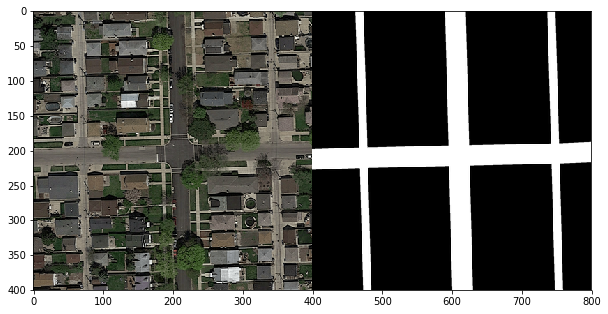

In [6]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [7]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [8]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0



In [9]:
X = np.asarray(imgs)
Y = np.asarray(gt_imgs)

In [10]:
print(X.shape)
print(Y.shape)

(100, 400, 400, 3)
(100, 400, 400)


In [11]:
from sklearn import cross_validation
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2)
x_test.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(20, 400, 400, 3)

In [12]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [13]:


batch_size = 48
num_classes = 2
epochs = 20

# input image dimensions
img_rows, img_cols = 400, 400

# the data, shuffled and split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    #x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    #x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [14]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (80, 400, 400, 3)
80 train samples
20 test samples


In [15]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 1)
y_test = keras.utils.to_categorical(y_test, 1)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dropout(0.3))
model.add(Dense(300000, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(Y.shape[1], activation='sigmoid'))

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 398, 398, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 398, 398, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 396, 396, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 396, 396, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 198, 198, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2509056)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2509056)           0         
__________

In [39]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.1)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: Error when checking target: expected dense_12 to have 2 dimensions, but got array with shape (80, 400, 400, 2)

In [17]:
model.save_weights('first_try11.h5')

In [18]:
def load_test_imgs():
    #1444 tiles per image
    n=50
    test_directory = "test_set_images/test_"
    imgs = [load_image(test_directory + str(i)+"/test_"+str(i)+".png") for i in range(1,n+1)]
    img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    return imgs, np.asarray(img_patches)

imgs_test, a = load_test_imgs()

In [19]:
yolo = model.predict(a, batch_size=batch_size)

In [20]:
print(yolo.shape)
print(yolo[0])
G = np.zeros((72200,1))
for i in range(len(G)):
    if yolo[i]<0.5:
        G[i] = 0
    else:
        G[i] = 1

(72200, 1)
[ 0.23558412]


In [21]:
def showTestImg(idx):

    w = 608
    h = 608
    size= 1444
    predicted_im = label_to_img(w, h, patch_size, patch_size, G[size*idx:size*(idx+1)])
    cimg = concatenate_images(imgs_test[idx], predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

    new_img = make_img_overlay(imgs_test[idx], predicted_im)

    plt.imshow(new_img)

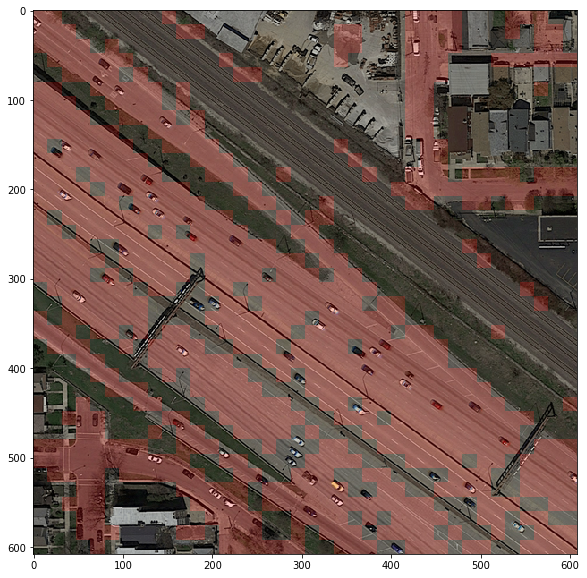

In [22]:
#la 5, 6 et 8 sont pas mal
idx_test = 8
showTestImg(idx_test)

In [23]:
def saveTestImgsOutput():
    w = 608
    h = 608
    size = 1444
    for i in range(50):
        predicted_im = label_to_img(w, h, patch_size, patch_size, G[size*i:size*(i+1)])
        nameToSave = 'test_set_results_bis/img_'+str(i+1)+'.png'
        H = np.zeros((w,h,3))
        H[predicted_im>0.5] = [1,1,1]
        H[predicted_im<0.5] = [0,0,0]
        matplotlib.image.imsave(nameToSave, H)
saveTestImgsOutput()

In [18]:
Img_Size = 400
Num_Bins = 0
def Build_Classification_Model():
    Kernel_Size_Val=4
    import keras
    from keras.models import Model
    from keras.layers import Flatten, Dense, Input, Reshape,concatenate,BatchNormalization,Dropout,Activation,Conv2D,MaxPool2D

    Input_Img=Input(shape=(Img_Size,Img_Size,3),name='Main_Input')
    #The First Conv Layer + BatchNormalization
    X=Conv2D(filters=4,kernel_size=Kernel_Size_Val,activation='relu',name='First_Conv_0',padding='same')(Input_Img)
    X=Conv2D(filters=4,kernel_size=Kernel_Size_Val,activation='relu',name='First_Conv_1',padding='same')(X)

    X=Conv2D(filters=8,kernel_size=Kernel_Size_Val,activation='relu',name='Second_Con_0',padding='same')(X)
    X=Conv2D(filters=8,kernel_size=Kernel_Size_Val,activation='relu',name='Second_Conv_1',padding='same')(X)
    """
    X=Conv2D(filters=16,kernel_size=Kernel_Size_Val,activation='relu',name='Third_Conv_0',padding='same')(X)
    X=Conv2D(filters=16,kernel_size=Kernel_Size_Val,activation='relu',name='Third_Conv_1',padding='same')(X)

    X=Conv2D(filters=32,kernel_size=Kernel_Size_Val,activation='relu',name='Fourth_Conv_0',padding='same')(X)
    X=Conv2D(filters=32,kernel_size=Kernel_Size_Val,activation='relu',name='Fourth_Conv_1',padding='same')(X)

    X=Conv2D(filters=64,kernel_size=Kernel_Size_Val,activation='relu',name='Fifth_Conv_0',padding='same')(X)
    X=Conv2D(filters=64,kernel_size=Kernel_Size_Val,activation='relu',name='Fifth_Conv_1',padding='same')(X)"""


    X=Conv2D(filters=Num_Bins+1,kernel_size=Kernel_Size_Val,activation='softmax',padding='same')(X)

    MyModel=Model(Input_Img,X)
    MyModel.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])    
    print(MyModel.summary())
    return MyModel
m = Build_Classification_Model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Main_Input (InputLayer)      (None, 400, 400, 3)       0         
_________________________________________________________________
First_Conv_0 (Conv2D)        (None, 400, 400, 4)       196       
_________________________________________________________________
First_Conv_1 (Conv2D)        (None, 400, 400, 4)       260       
_________________________________________________________________
Second_Con_0 (Conv2D)        (None, 400, 400, 8)       520       
_________________________________________________________________
Second_Conv_1 (Conv2D)       (None, 400, 400, 8)       1032      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 400, 400, 1)       129       
Total params: 2,137
Trainable params: 2,137
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
m.fit(x_train, y_train,
          batch_size=16,
          epochs=epochs,
          verbose=1,
          validation_split=0.1)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 72 samples, validate on 8 samples
Epoch 1/20
72/72 [==============================] - 29s 398ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/20
72/72 [==============================] - 32s 438ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/20
72/72 [==============================] - 32s 439ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/20
72/72 [==============================] - 33s 464ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/20
72/72 [==============================] - 31s 433ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/20
72/72 [==============================] - 31s 431ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 7/20
72/72 [==============================] - 32s 443ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss:

ValueError: Error when checking target: expected dense_2 to have 2 dimensions, but got array with shape (20, 400, 400, 1)

In [22]:
'''Trains a simple deep NN on the MNIST dataset.
Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

batch_size = 128
num_classes = 10
epochs = 20

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])



(60000, 28, 28)
60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])